In [2]:
%cd ../project/

C:\cygwin64\home\evger\thesis\project


In [3]:
from typing import Union, List, Dict

from hft.utils import logger
logger.to_file = True
logger.fmt_string = "%(message)s"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from hft.backtesting.data import OrderStatus, OrderRequest
from hft.backtesting.strategy import Strategy
from hft.utils.data import Trade, OrderBook
from hft.backtesting import readers, backtest
from hft.backtesting.output import StorageOutput
from hft.backtesting.readers import TimeLimitedReader
from hft.units.filters import Filters
from hft.units.metrics import *
from hft.utils.consts import Statuses, QuoteSides, TradeSides

In [4]:
class GatlingMM(Strategy):
  def __init__(self, side_volume, filter_depth=3):
    super().__init__(filter_depth=filter_depth)
    self.side_volume = side_volume
    self.volumes_left = {} # add cancellation policy

  def define_orders(self, row: Union[Trade, OrderBook],
                    statuses: List[OrderStatus],
                    memory: Dict[str, Union[Trade, OrderBook]]) -> List[OrderRequest]:
    if self.balance.get(row.symbol, None) is None:
      if type(row) == OrderBook and self.balance.get(row.symbol, None) is None:
        # Initialize first orders
        ask_volume = min(self._get_allowed_volume(row.symbol, memory, QuoteSides.ASK), self.side_volume)
        self.volumes_left[(row.symbol, QuoteSides.ASK)] = self.side_volume - ask_volume
        ask_order = OrderRequest.create_ask(row.ask_prices[0], ask_volume, row.symbol, row.timestamp)

        bid_volume = min(self._get_allowed_volume(row.symbol, memory, QuoteSides.BID), self.side_volume)
        self.volumes_left[(row.symbol, QuoteSides.BID)] = self.side_volume - bid_volume
        bid_order = OrderRequest.create_bid(row.bid_prices[0], bid_volume, row.symbol, row.timestamp)

        return [ask_order, bid_order]
    elif self.balance.get(row.symbol, None) is not None:
      orders = []
      for status in statuses:
        order: OrderRequest = self.active_orders[status.id]

        if status.status != Statuses.PARTIAL: # finished and cancel
          self.volumes_left[(order.symbol, order.side)] += order.volume - order.volume_filled
        elif status.status == Statuses.PARTIAL:
          self.volumes_left[(order.symbol, order.side)] += status.volume

      for (symbol, side), left_volume in self.volumes_left.items():
        if left_volume > 500:
          volume = min(left_volume, self._get_allowed_volume(symbol, memory, side))
          self.volumes_left[(symbol, side)] -= volume

          if side == QuoteSides.BID:
            price = memory[('orderbook', symbol)].bid_prices[0]
          else:
            price = memory[('orderbook', symbol)].ask_prices[0]

          neworder = OrderRequest.create(price, volume, symbol, side, row.timestamp)
          orders.append(neworder)

      return orders
    return []

In [5]:
class OrdersOutput(StorageOutput):
  def __init__(self, instant_metric_names, time_metric_names):
    super().__init__(instant_metric_names, time_metric_names)
    self.prices = defaultdict(list)
    self.orders = defaultdict(list)
    self.snapshots = defaultdict(list)
    self.trades = defaultdict(list)
    
  def time_metric_action(self, timestamp, labels, object):
    pass

  def snapshot_action(self, timestamp: datetime.datetime, object: OrderBook):
    self.snapshots[object.symbol].append((timestamp, object.bid_prices[0], object.ask_prices[0]))

  def instant_metric_action(self, timestamp, labels, object):
    pass

  def trade_action(self, timestamp: datetime.datetime, object: Trade):
    self.trades[(object.symbol, object.side)].append((object.timestamp, object.price, object.volume))

  def additional_action(self, timestamp: datetime.datetime, labels, object: OrderRequest):
    if 'order-request' in labels:
        self.orders[(labels[1], labels[2])].append((timestamp, object.price, object.volume))

  def metric_action(self, timestamp: datetime.datetime, object):
    pass

In [68]:
reader = TimeLimitedReader('../tests/resources/huge_dataset/orderbook_10_03_20.csv.gz', 
                         limit_time='70 min',
                         skip_time='50 min',
                         trades_file='../tests/resources/huge_dataset/trades_10_03_20.csv.gz',
                         nrows=500000)

delay = 1000 # millisec
target_contracts = 3000
filter_depth=4

output = OrdersOutput([], [])
output.balances = []
strategy = GatlingMM(target_contracts, filter_depth=filter_depth)
strategy.balance_listener = output.balances.append

backtester = backtest.Backtest(reader, strategy, output=output, delay=delay)

In [69]:
start = time.time()
backtester.run(tqdm_enabled=True)
finish = time.time()
t = finish - start

print(f'time taken: {t}')

Current time: 2020-03-10 19:15:10.970000:   0%|          | 4/307730 [00:00<03:50, 1332.37it/s]

time taken: 76.38905835151672


In [70]:
# depth = 10, time = 536 seconds
# depth = 5,  time = 550 seconds

# ---------------- REFACTORED ---------------
# depth = 10, time = 256 seconds
# 300k rows, time=256 seconds 

# Loading 10 items (depth-to-load) improves speed of the process
# ---
# Refactor 2
# Removed random access (by index) to itertuples() -> improvement x12 (6500 it/s instead of 500 it/s)

# Display Unrealized P&L plots

In [71]:
balance = pd.DataFrame(output.balances, columns=['USD', 'XBTUSD', 'ETHUSD', 
                                                 'xbt-pos-price', 'xbt-pos', 
                                                 'eth-pos-price', 'eth-pos',
                                                'xbt-midpoint', 'eth-midpoint', 'timestamp'])
balance['eth-upnl'] = (1./balance['eth-pos-price'] - 1./balance['eth-midpoint']) * balance['eth-pos']
balance['xbt-upnl'] = (1./balance['xbt-pos-price'] - 1./balance['xbt-midpoint']) * balance['xbt-pos']
balance = balance.fillna(0)

In [72]:
balance.timestamp.min(), balance.timestamp.max()

(Timestamp('2020-03-10 18:25:14.318000'),
 Timestamp('2020-03-10 19:15:10.970000'))

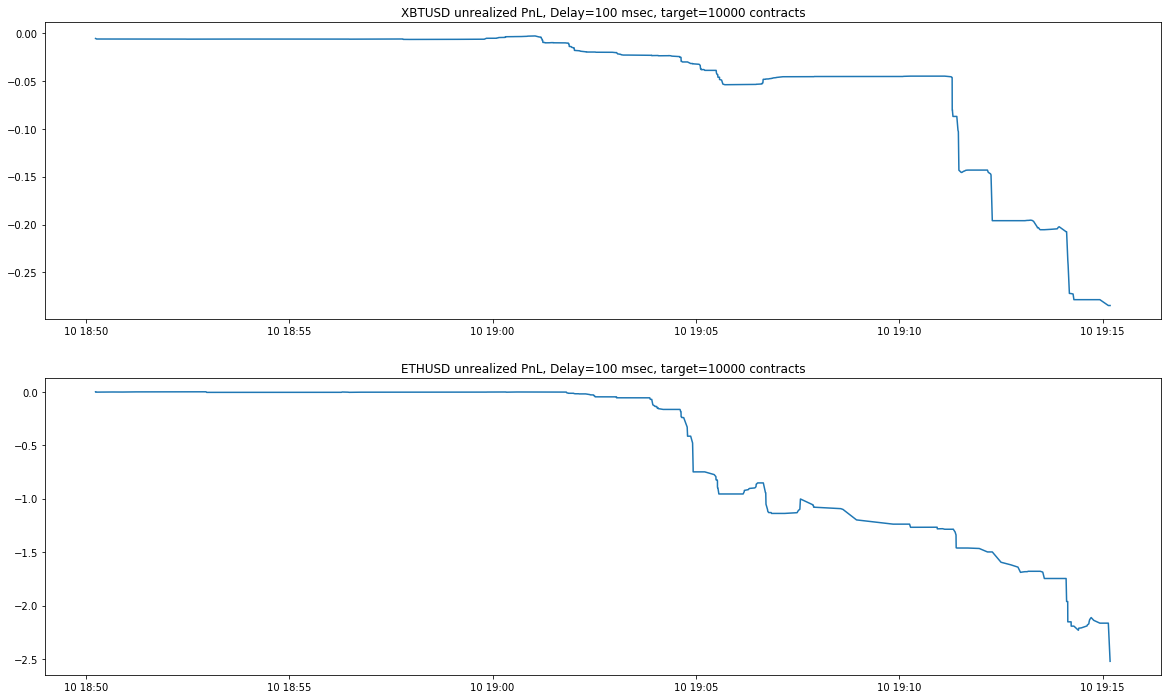

In [82]:
f = plt.figure(figsize=(20,12))
# plt.plot(balances_df['timestamp'], balances_df['balance'])
xbt_plot = f.add_subplot(211)
eth_plot = f.add_subplot(212)

# xbt_plot.plot(balance['timestamp'][:5000], balance['xbt-upnl'][:5000])
# eth_plot.plot(balance['timestamp'][:5000], balance['eth-upnl'][:5000])
xbt_plot.plot(balance['timestamp'][1300:], balance['xbt-upnl'][1300:])
eth_plot.plot(balance['timestamp'][1300:], balance['eth-upnl'][1300:])

xbt_plot.set_title(f'XBTUSD unrealized PnL, Delay={delay} msec, target={target_contracts} contracts')
eth_plot.set_title(f'ETHUSD unrealized PnL, Delay={delay} msec, target={target_contracts} contracts')
plt.savefig('upnl.png')
plt.show()

# Shows prices, orders and trades plots (if Storage enabled)

In [77]:
def plot_prices_orders(label, trades=True):
    prices_df = pd.DataFrame(output.snapshots[label], columns=['timestamp', 'bid-price', 'ask-price'])
    orders_df_bid = pd.DataFrame(output.orders[(label, QuoteSides.BID)], columns=['timestamp', 'price', 'volume'])
    orders_df_ask = pd.DataFrame(output.orders[(label, QuoteSides.ASK)], columns=['timestamp', 'price', 'volume']) 
    trades_df_buy = pd.DataFrame(output.trades[(label, TradeSides.BUY)], columns=['timestamp', 'price', 'volume']) 
    trades_df_sell = pd.DataFrame(output.trades[(label, TradeSides.SELL)], columns=['timestamp', 'price', 'volume'])
    
    if trades:
        f = plt.figure(figsize=(36,20))
        # plt.plot(balances_df['timestamp'], balances_df['balance'])
        trades_plot = f.add_subplot(211)
        orders_plot = f.add_subplot(212)

        trades_plot.set_title(f'{label} with trade scatter')

        trades_plot.set(xlabel='Time', ylabel='Price')
        trades_plot.plot(prices_df['timestamp'], prices_df['bid-price'], label='bid price')
        trades_plot.plot(prices_df['timestamp'], prices_df['ask-price'], label='ask price')
        trades_plot.scatter(trades_df_buy['timestamp'], trades_df_buy['price'], label='trades BUY')
        trades_plot.scatter(trades_df_sell['timestamp'], trades_df_sell['price'], label='trades SELL')
        trades_plot.legend()
    else:
        f = plt.figure(figsize=(18, 10))
        orders_plot = f.add_subplot(111)

    
    orders_plot.set_title(f'{label} with simulated orders scatter')

    orders_plot.plot(prices_df['timestamp'], prices_df['bid-price'], label='bid price')
    orders_plot.plot(prices_df['timestamp'], prices_df['ask-price'], label='ask price')
    orders_plot.set(xlabel='Time', ylabel='Price')
    orders_plot.scatter(orders_df_bid['timestamp'], orders_df_bid['price'], label='orders bid')
    orders_plot.scatter(orders_df_ask['timestamp'], orders_df_ask['price'], label='orders ask')

    
    orders_plot.legend()
    plt.plot()

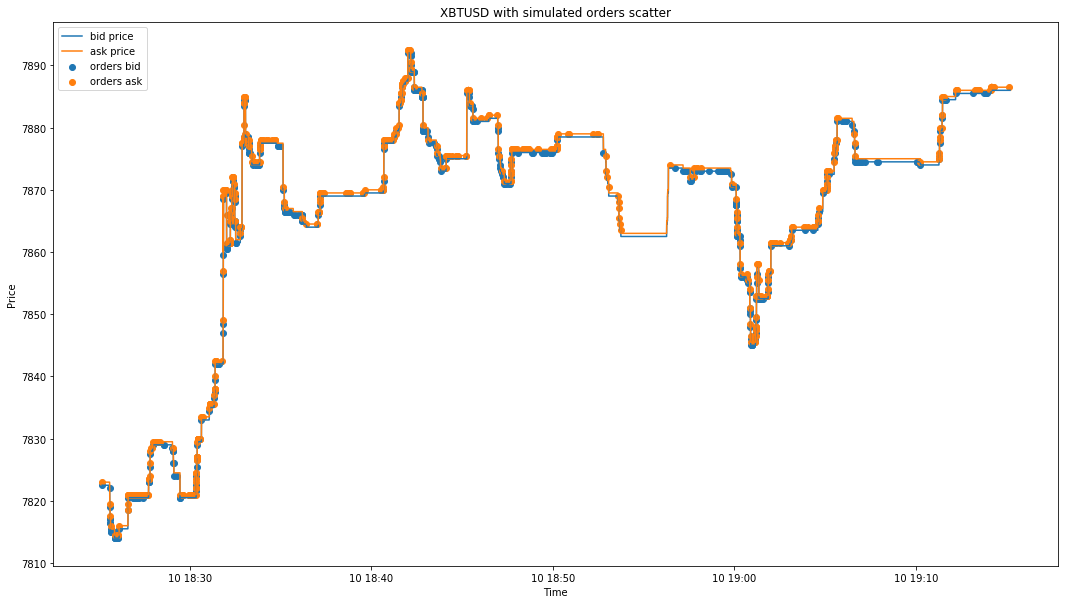

In [78]:
plot_prices_orders('XBTUSD', False)

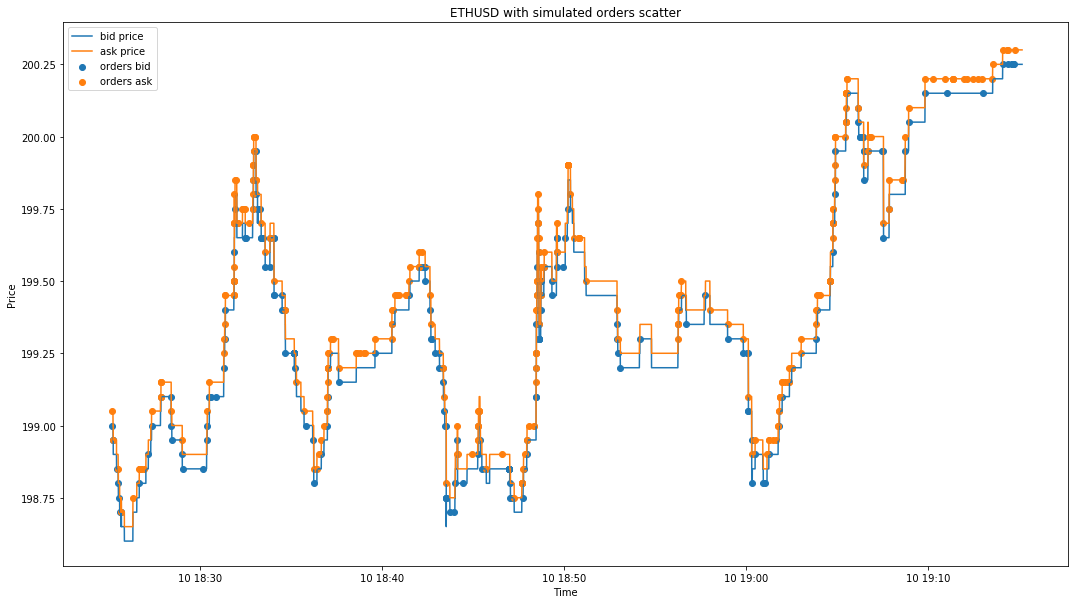

In [79]:
plot_prices_orders('ETHUSD', False)